### Códigos de la autora sobre equilibrio de Nash

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from gurobipy import Model, GRB
import re
import random

# Configuración visual
plt.rcParams['text.usetex'] = True
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'serif'

# Archivos de entrada
converge_file = r"C:\Users\nico_\Desktop\Procesos\Proyecto\JavieraSimulations\RESULTADOS_P_PP_1.dat"
parametros_file = r"C:\Users\nico_\Desktop\Procesos\Proyecto\JavieraSimulations\beneficios_capacidades_1.dat"

# Leer resultados de programas
resultados_df = pd.read_csv(converge_file, sep='\t', names=['Programa', 'Probabilidad', 'Lugares'], engine='python')
resultados_df['Lugares'] = resultados_df['Lugares'].str.strip('),').str.replace(r'[^\d,]', '', regex=True)

# Leer parámetros desde el archivo DAT
with open(parametros_file, 'r') as file:
    parametros_lines = file.readlines()

# Procesar conjuntos y parámetros
I = list(map(int, re.findall(r'\d+', parametros_lines[0])))
L = list(map(int, re.findall(r'\d+', parametros_lines[2])))

BI, BL, KI, KL = {}, {}, {}, {}
Perd, M = None, None
reading_section = None

for line in parametros_lines:
    if 'param BI :=' in line:
        reading_section = 'BI'
    elif 'param BL :=' in line:
        reading_section = 'BL'
    elif 'param KI :=' in line:
        reading_section = 'KI'
    elif 'param KL :=' in line:
        reading_section = 'KL'
    elif 'param Perd :=' in line:
        Perd = int(re.search(r'\d+', line).group())
    elif 'param M :=' in line:
        M = int(re.search(r'\d+', line).group())
    elif ';' in line:
        reading_section = None
    elif reading_section:
        key, value = re.findall(r'\d+', line)
        if reading_section == 'BI':
            BI[int(key)] = float(value)
        elif reading_section == 'BL':
            BL[int(key)] = float(value)
        elif reading_section == 'KI':
            KI[int(key)] = float(value)
        elif reading_section == 'KL':
            KL[int(key)] = float(value)

# Parámetro G
G = max(max(BI.values(), default=0), max(BL.values(), default=0))

def resolver_con_gurobi(Pmg):
    model = Model("SistemaEcuaciones")
    model.Params.OutputFlag = 0

    gamma = model.addVar(vtype=GRB.CONTINUOUS, name="gamma")
    pp_vars = {j: model.addVar(vtype=GRB.CONTINUOUS, lb=0, ub=1, name=f"pp_{j}") for j in I + L}
    y_vars = {j: model.addVar(vtype=GRB.BINARY, name=f"y_{j}") for j in I + L}

    for j in I + L:
        capacidad = KI[j] if j in I else KL[j]
        beneficio = BI[j] if j in I else BL[j]

        model.addConstr(
            G * (1 - y_vars[j]) + beneficio * (1 - pp_vars[j] * (M / capacidad)) * (1 - Pmg[j]) - Perd * Pmg[j] >= gamma,
            name=f"restriccion1_{j}"
        )
        model.addConstr(
            beneficio * (1 - pp_vars[j] * (M / capacidad)) * (1 - Pmg[j]) - Perd * Pmg[j] <= gamma,
            name=f"restriccion2_{j}"
        )
        model.addConstr(pp_vars[j] <= y_vars[j], name=f"restriccion3_{j}")

    model.addConstr(sum(pp_vars[j] for j in I + L) == 1, name="suma_proporciones")
    model.setObjective(gamma, GRB.MINIMIZE)
    model.optimize()

    if model.status != GRB.OPTIMAL:
        raise ValueError("No se pudo encontrar una solución óptima.")

    soluciones = {
        'gamma': gamma.X,
        **{j: {'pp': pp_vars[j].X, 'y': y_vars[j].X} for j in I + L}
    }
    return soluciones

def simulacion_monte_carlo(dias_validos_deseados=150):
    Pmg = {j: 0 for j in I + L}
    proporciones_ilegales = []
    dias_validos = []

    dia = 1
    while len(proporciones_ilegales) < dias_validos_deseados:
        programa_seleccionado = random.choices(
            resultados_df['Programa'],
            weights=resultados_df['Probabilidad'],
            k=1
        )[0]

        lugares_inspeccionados = list(map(int, resultados_df[resultados_df['Programa'] == programa_seleccionado]['Lugares'].values[0].split(',')))
        x_dia = {j: 1 if j in lugares_inspeccionados else 0 for j in I + L}

        for j in Pmg:
            Pmg[j] = (Pmg[j] * (dia - 1) + x_dia[j]) / dia

        try:
            soluciones = resolver_con_gurobi(Pmg)
            suma_ilegales = sum(soluciones[j]['pp'] for j in I)
            proporciones_ilegales.append(suma_ilegales * 100)
            dias_validos.append(len(proporciones_ilegales) - 1)
        except Exception:
            pass

        dia += 1

      # === GRAFICO ===
    plt.figure(figsize=(16, 6))
    plt.plot(dias_validos, proporciones_ilegales, color='black', linewidth=2, zorder=3)
    plt.axhline(y=52, color='black', linestyle=':', linewidth=1.5, label=r'$I_{OR} = 52\%$', zorder=2)

    plt.xlabel("Periods", fontsize=27, labelpad=15)
    plt.ylabel(r"$I_{OR}(\tau)$", fontsize=27, labelpad=15)

    max_y = max(proporciones_ilegales) + 1
    plt.ylim(40, max_y)
    plt.xticks(ticks=range(0, dias_validos_deseados + 1, 15), fontsize=17)

    ticks_y = sorted(set([y for y in np.arange(50, np.ceil(max_y / 10) * 10, 5)] + [52]))
    plt.gca().set_yticks(ticks_y)
    plt.gca().set_yticklabels([f"{int(t)}\\%" for t in ticks_y], fontsize=17, color='black')

    plt.grid(False)
    plt.tight_layout()

    ruta_guardado = r"C:\Users\nico_\Desktop\Procesos\Proyecto\JavieraSimulations\simulacion_montecarlo1.pdf"
    plt.savefig(ruta_guardado, format='pdf', dpi=300)
    plt.show()

    print(f"Gráfico guardado en: {ruta_guardado}")

    # === ESTADÍSTICAS ===
    if proporciones_ilegales:
        ior_inicial = proporciones_ilegales[0]
        ior_min = min(proporciones_ilegales)
        ior_argmin = np.argmin(proporciones_ilegales)

        ior_media_estacionaria = np.mean(proporciones_ilegales[-100:])
        dia_baja_52 = next((i for i, val in enumerate(proporciones_ilegales) if val <= 52), None)

        print("\n=== Estadísticas IOR ===")
        print(f"IOR inicial: {ior_inicial:.2f}%")
        print(f"IOR mínima: {ior_min:.2f}%")
        print(f"IOR promedio últimos 100 días: {ior_media_estacionaria:.2f}%")
        if dia_baja_52 is not None:
            print(f"Día relativo en que baja de 52%: {dia_baja_52}")
            return dia_baja_52
        else:
            print("No se alcanzó una IOR menor o igual al 52% en la simulación.")
            return ior_argmin
# # Ejecutar simulación
# simulacion_monte_carlo(dias_validos_deseados=150)


In [2]:
print(len(I)) #Cantidad de lugares ilegales
print(len(L)) #Cantidad de lugares legales
print(len(I+L)) #Intersección vacía, |I+L| = |I|+|L|

102
40
142


## Ejemplo de simulación Monte Carlo

Set parameter Username
Set parameter LicenseID to value 2682915
Academic license - for non-commercial use only - expires 2026-06-27


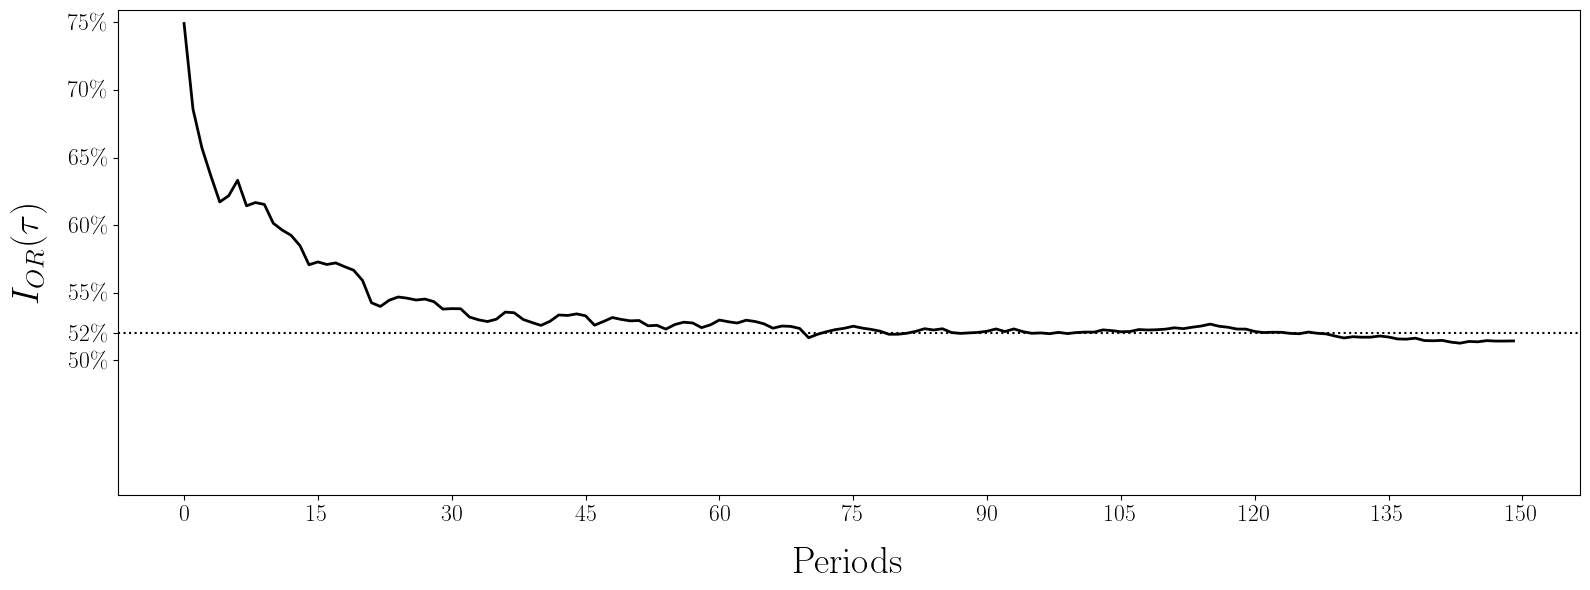

Gráfico guardado en: C:\Users\nico_\Desktop\Procesos\Proyecto\JavieraSimulations\simulacion_montecarlo1.pdf

=== Estadísticas IOR ===
IOR inicial: 74.92%
IOR mínima: 51.26%
IOR promedio últimos 100 días: 52.13%
Día relativo en que baja de 52%: 70


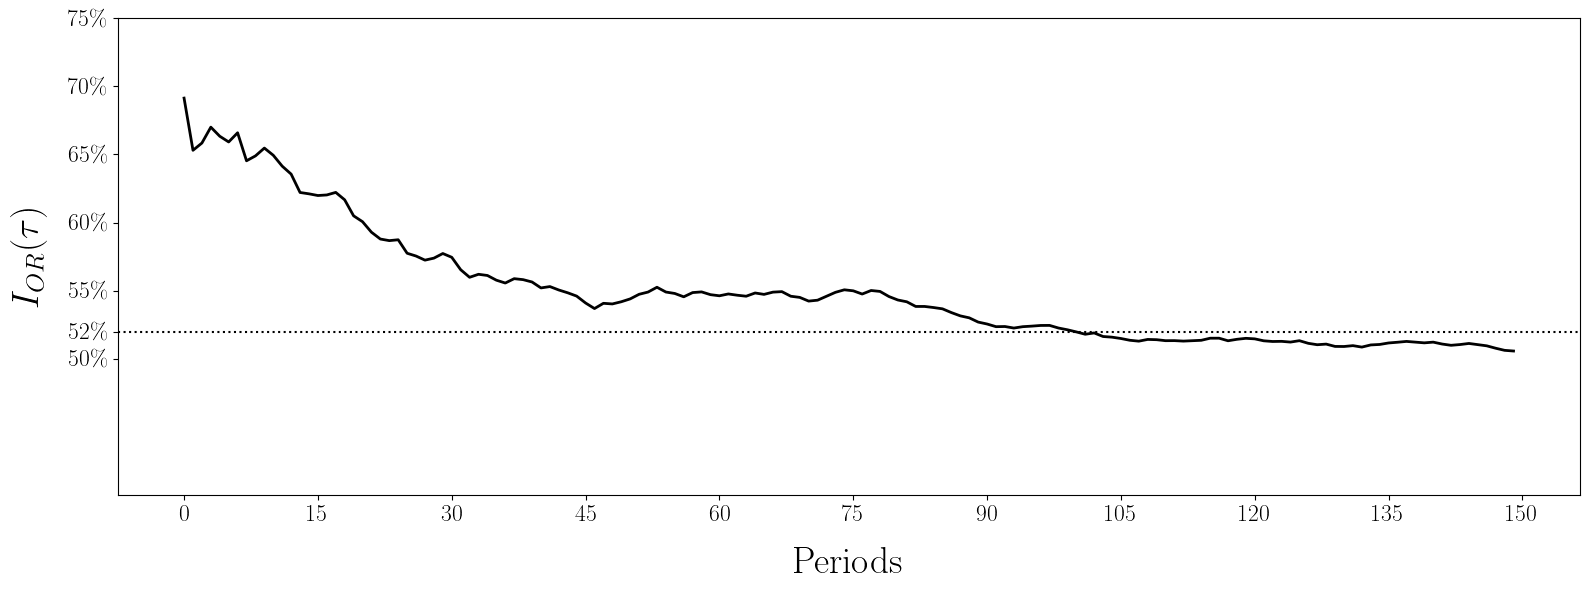

Gráfico guardado en: C:\Users\nico_\Desktop\Procesos\Proyecto\JavieraSimulations\simulacion_montecarlo1.pdf

=== Estadísticas IOR ===
IOR inicial: 69.14%
IOR mínima: 50.59%
IOR promedio últimos 100 días: 52.65%
Día relativo en que baja de 52%: 100


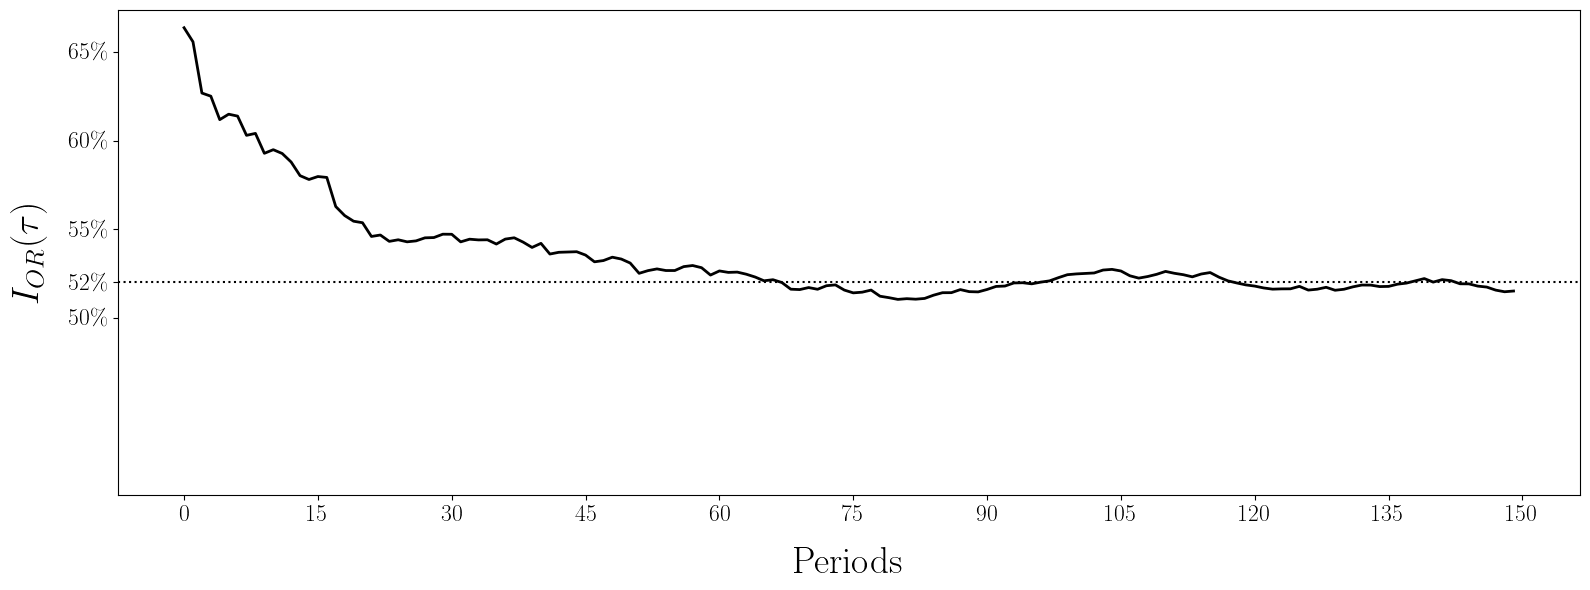

Gráfico guardado en: C:\Users\nico_\Desktop\Procesos\Proyecto\JavieraSimulations\simulacion_montecarlo1.pdf

=== Estadísticas IOR ===
IOR inicial: 66.36%
IOR mínima: 51.05%
IOR promedio últimos 100 días: 52.00%
Día relativo en que baja de 52%: 67


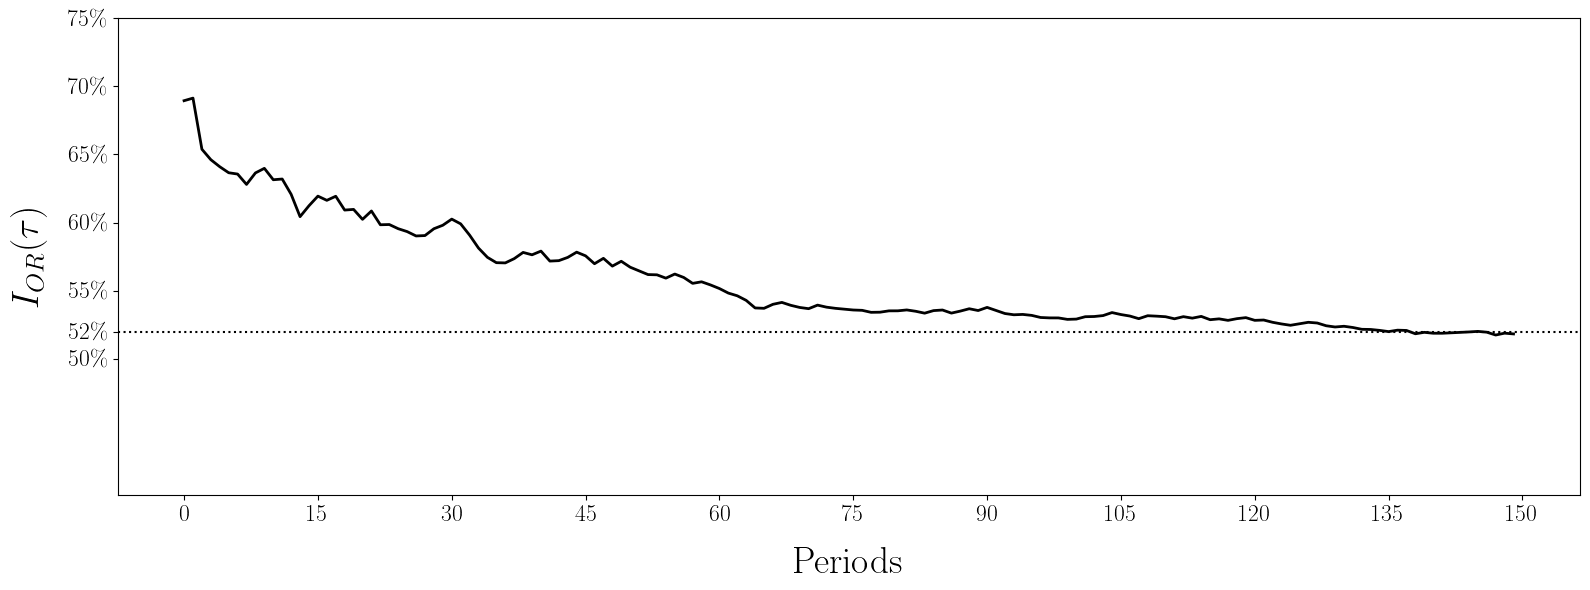

Gráfico guardado en: C:\Users\nico_\Desktop\Procesos\Proyecto\JavieraSimulations\simulacion_montecarlo1.pdf

=== Estadísticas IOR ===
IOR inicial: 68.95%
IOR mínima: 51.76%
IOR promedio últimos 100 días: 53.34%
Día relativo en que baja de 52%: 138


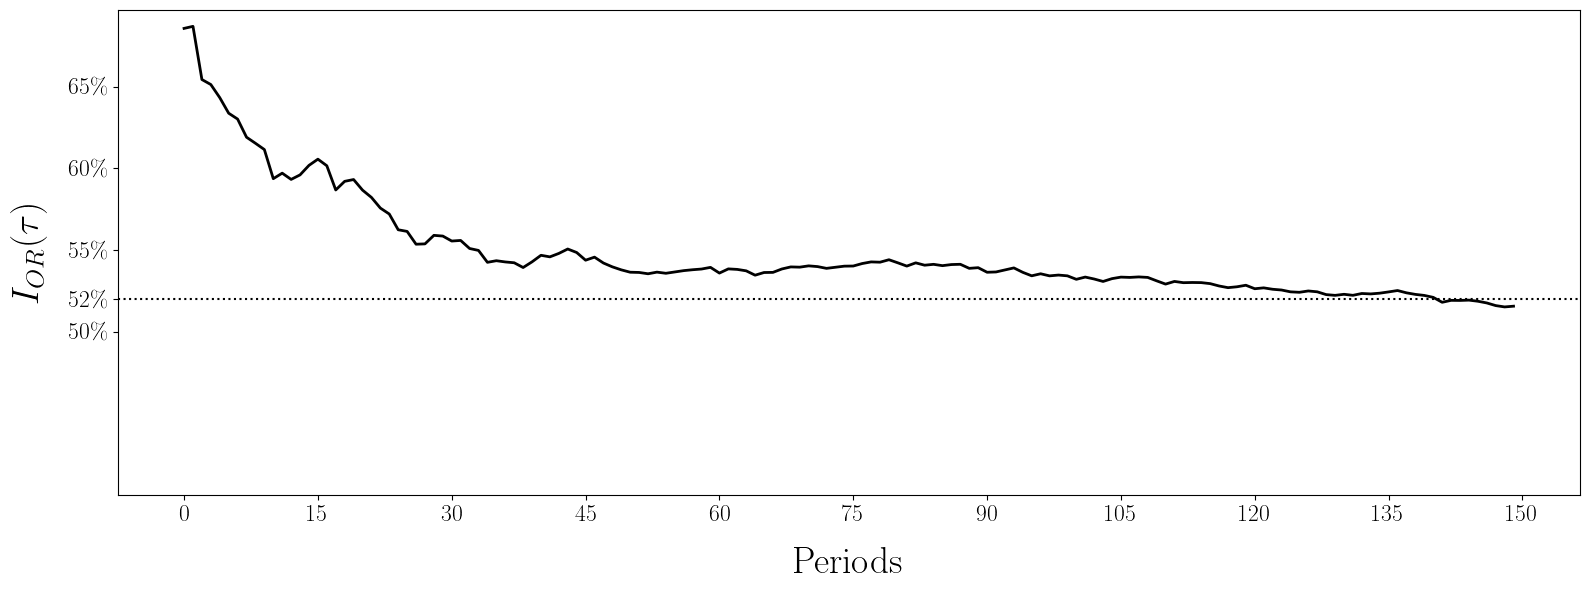

Gráfico guardado en: C:\Users\nico_\Desktop\Procesos\Proyecto\JavieraSimulations\simulacion_montecarlo1.pdf

=== Estadísticas IOR ===
IOR inicial: 68.57%
IOR mínima: 51.53%
IOR promedio últimos 100 días: 53.21%
Día relativo en que baja de 52%: 141


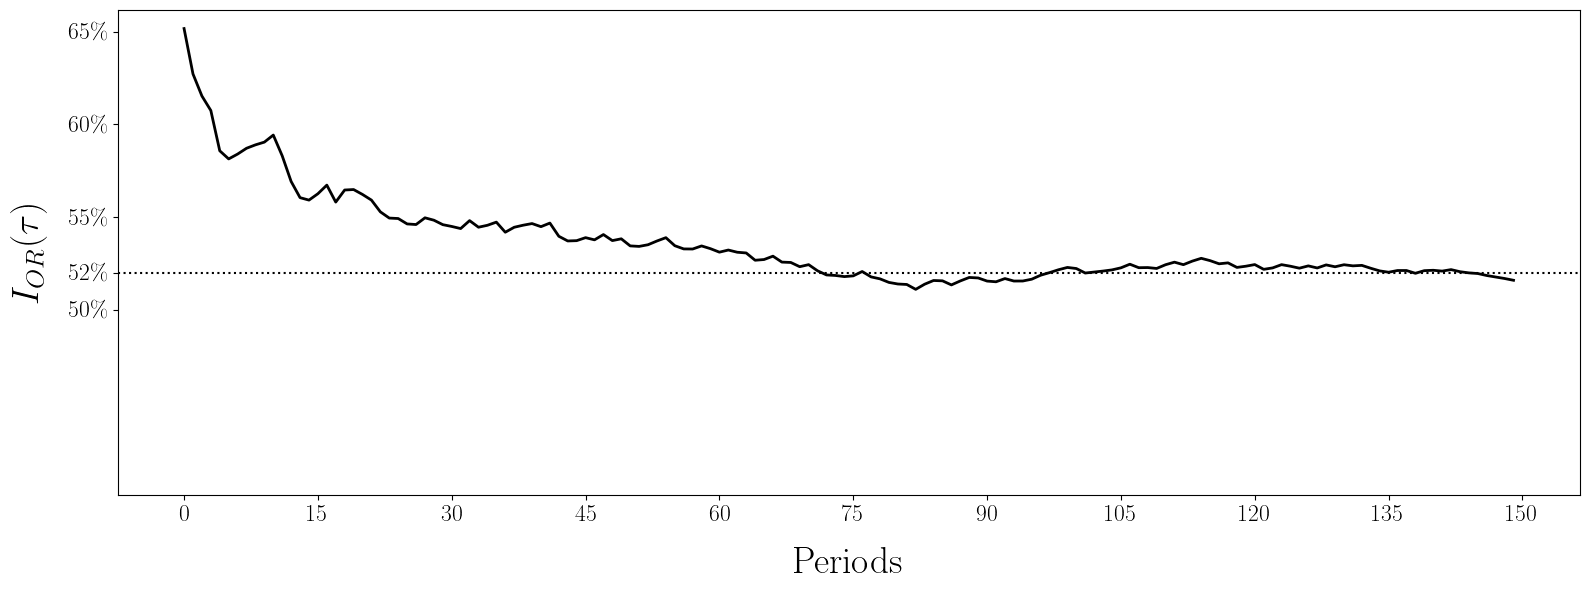

Gráfico guardado en: C:\Users\nico_\Desktop\Procesos\Proyecto\JavieraSimulations\simulacion_montecarlo1.pdf

=== Estadísticas IOR ===
IOR inicial: 65.16%
IOR mínima: 51.10%
IOR promedio últimos 100 días: 52.26%
Día relativo en que baja de 52%: 72


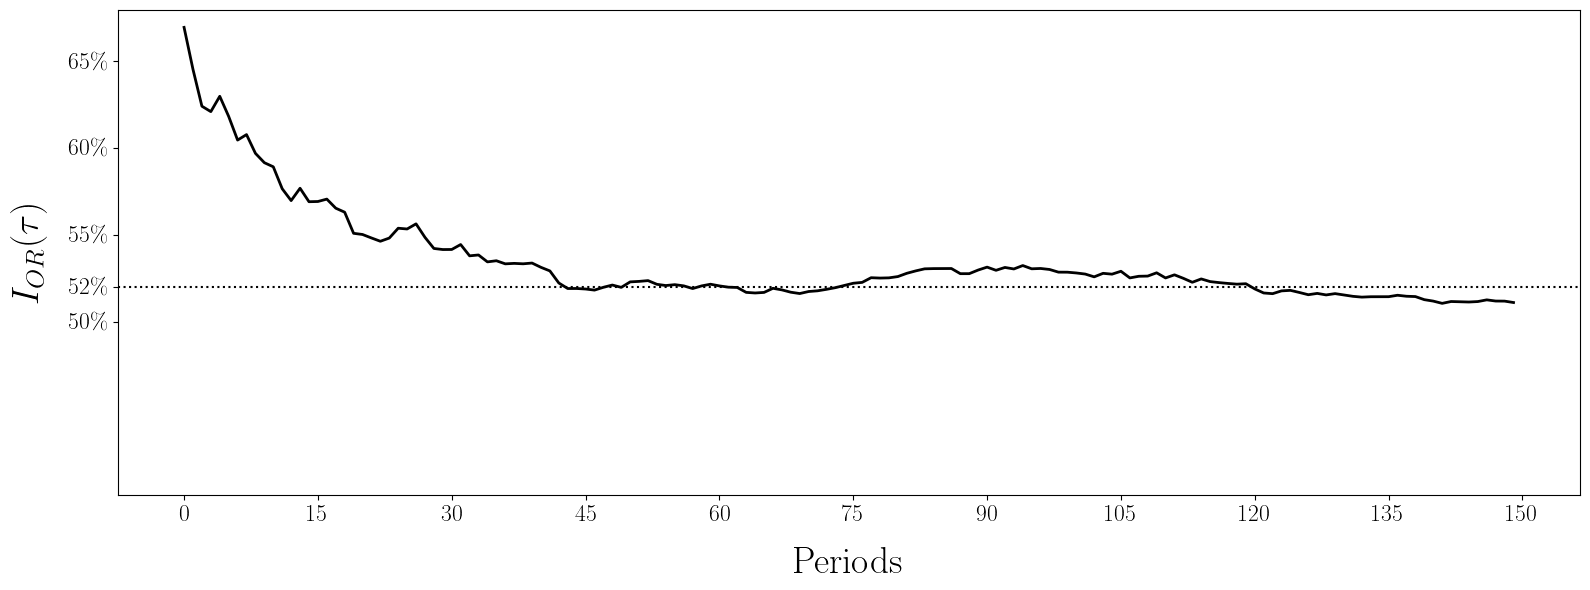

Gráfico guardado en: C:\Users\nico_\Desktop\Procesos\Proyecto\JavieraSimulations\simulacion_montecarlo1.pdf

=== Estadísticas IOR ===
IOR inicial: 66.94%
IOR mínima: 51.05%
IOR promedio últimos 100 días: 52.14%
Día relativo en que baja de 52%: 43


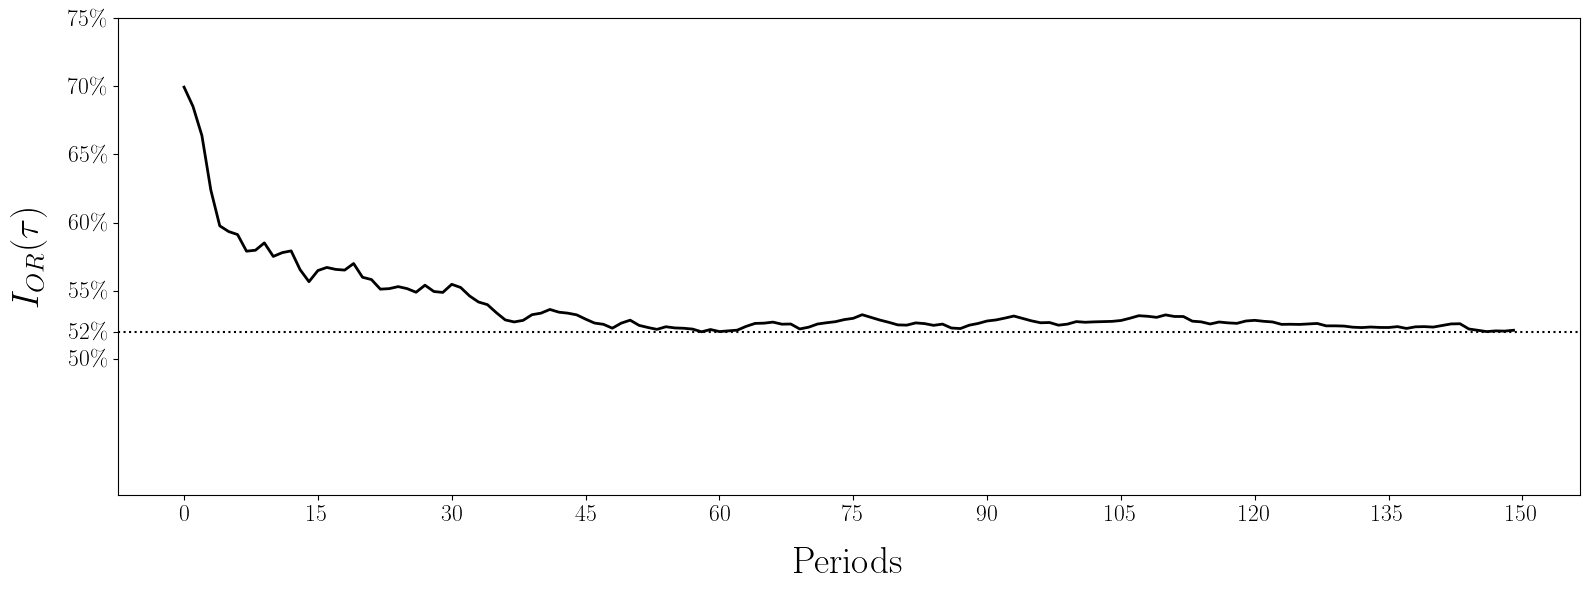

Gráfico guardado en: C:\Users\nico_\Desktop\Procesos\Proyecto\JavieraSimulations\simulacion_montecarlo1.pdf

=== Estadísticas IOR ===
IOR inicial: 69.94%
IOR mínima: 51.99%
IOR promedio últimos 100 días: 52.57%
Día relativo en que baja de 52%: 58


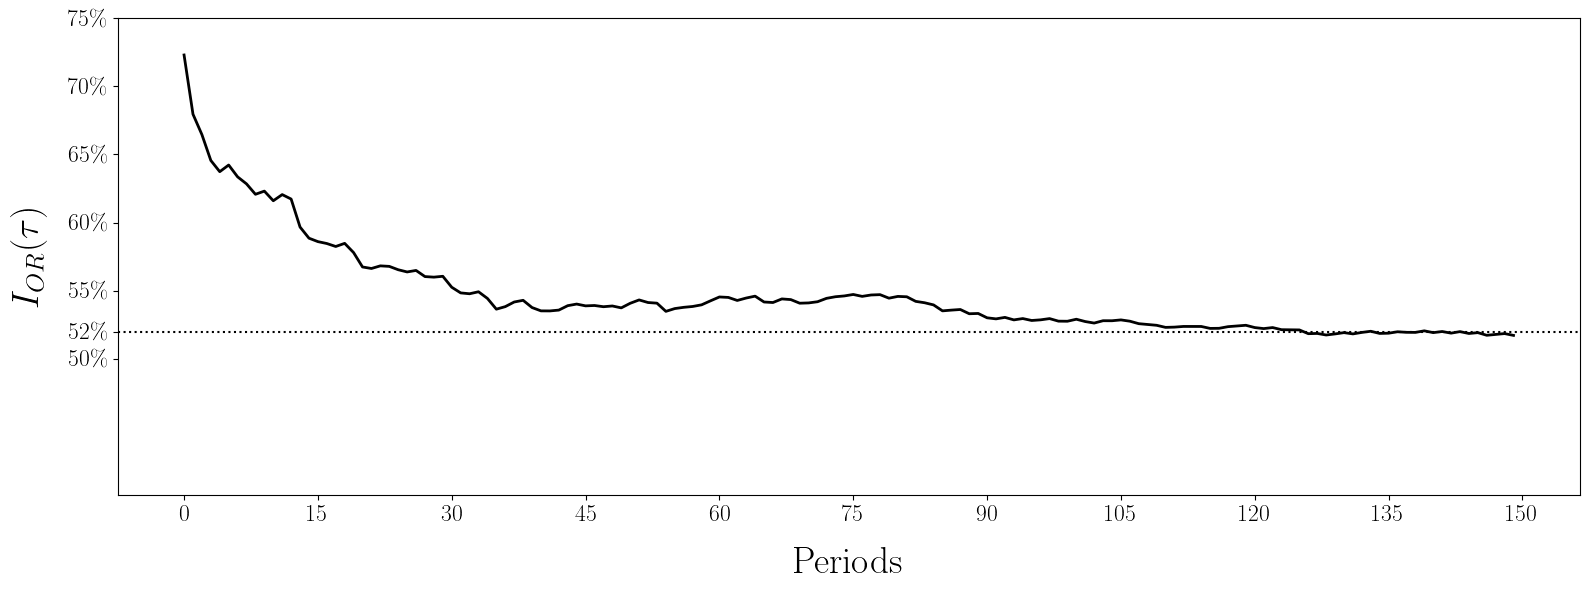

Gráfico guardado en: C:\Users\nico_\Desktop\Procesos\Proyecto\JavieraSimulations\simulacion_montecarlo1.pdf

=== Estadísticas IOR ===
IOR inicial: 72.30%
IOR mínima: 51.73%
IOR promedio últimos 100 días: 53.06%
Día relativo en que baja de 52%: 126


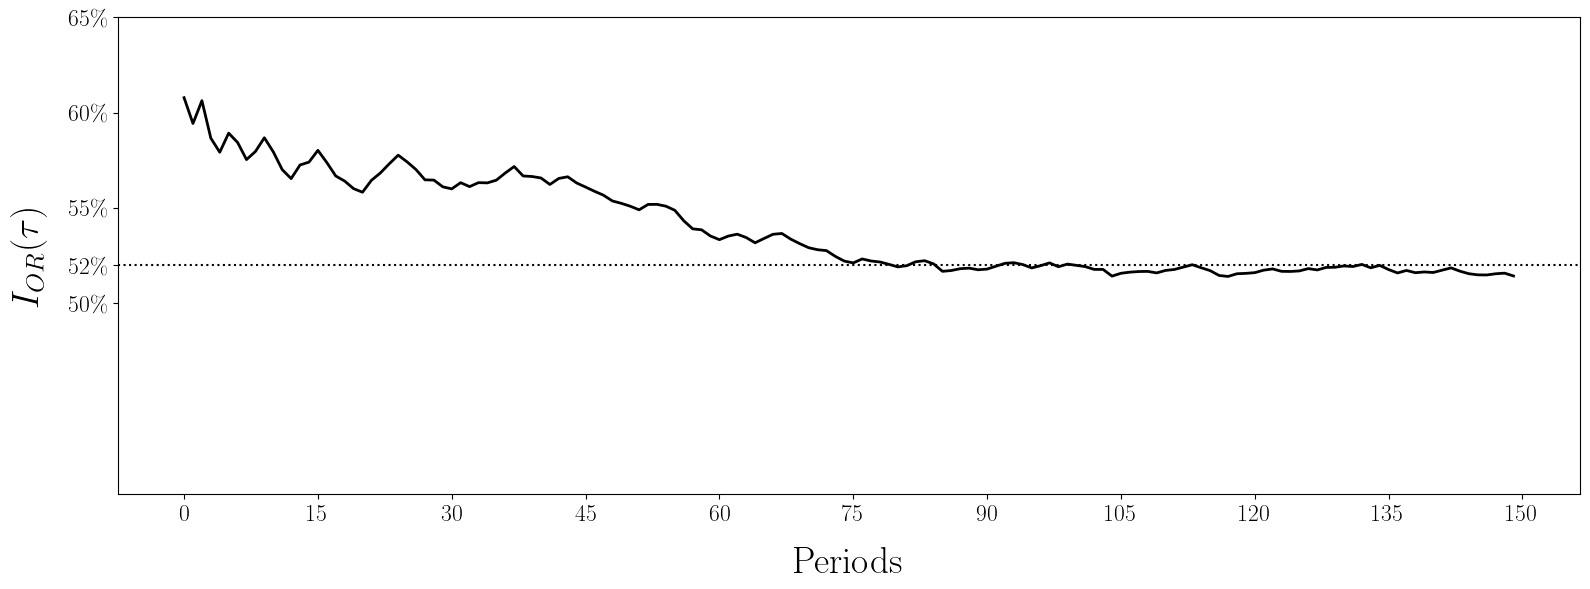

Gráfico guardado en: C:\Users\nico_\Desktop\Procesos\Proyecto\JavieraSimulations\simulacion_montecarlo1.pdf

=== Estadísticas IOR ===
IOR inicial: 60.78%
IOR mínima: 51.42%
IOR promedio últimos 100 días: 52.30%
Día relativo en que baja de 52%: 80
Promedio de tau: 89.5


In [3]:

dias = []
for n in range(0,10,1):
    dias.append(simulacion_monte_carlo(150))

print("Promedio de tau: "+str(np.mean(np.array(dias))))

## Obtención de $\mathbf{p}^*$ según $NE(\mathbb{P})$

In [4]:
Pmg = {j: 0 for j in I + L}

for n in resultados_df.index:
    p = resultados_df.loc[n,"Probabilidad"]
    lugares = resultados_df.loc[n,"Lugares"].split(",")
    for m in lugares:
        Pmg[int(m)] += p

soluciones_optimas = resolver_con_gurobi(Pmg)

pp = {j: 0 for j in I + L}

for n in Pmg.keys():
    n=int(n)

    capacidad = KI[n] if n in I else KL[n]
    beneficio = BI[n] if n in I else BL[n]
    
    pp[n] = soluciones_optimas[n]["pp"]*M
    pp[n] = pp[n]

#Hay que reconstruir los p_j debido a que están escritos como combinación convexa de otros objetos que escapan de este trabajo...


print(sum(soluciones_optimas[n]["pp"] for n in I)) #IOR*

0.47680911063251125


In [5]:
capacidadM = {n: M for n in I+L} #Capacidad infinita

##  $\tau$ y $Ior(\tau)$

In [6]:
def MarkovMatrix(Popt,k,M,eps): #Creación de Matriz de Markov
    MM = np.zeros((M+1,M+1))

    for i in range(0,M+1,1):
        C2 = abs(Popt-i)*(1+eps)

        Limsup = min(k, int(np.trunc(Popt+C2)),M)
        Liminf = max(0, int(np.ceil(Popt-C2)))

        if C2 == 0:
            MM[Liminf, Liminf] = 1.0
            continue
        
        elif C2 < 0.5:
            t = int((-1)*(min(Popt-Liminf, Limsup-Popt)-Popt))
            MM[t,t]  = 1
            continue

        elif C2 == 0.5:
            MM[Liminf,Limsup]  = 0.5
            MM[Liminf,Liminf]  = 0.5
            MM[Limsup, Limsup] = 0.5
            MM[Limsup, Liminf] = 0.5
        
            continue

        C1 = sum(C2-abs(Popt-j) for j in range(Liminf,Limsup+1,1))
        
        for j in range(Liminf,Limsup+1,1):
            
            MM[i,j] = C2 - abs(Popt-j) 
        
        
        MM[i] *= 1/C1

    return MM

def printt(M,a):
    print(np.round(M,a))
    return

def indices_a_borrar(P,Opt):
    D = np.diag(P)
    s = np.argmax(D)
    t = D[s]

    lista = []
    lista.append(s)

    if abs(t-1) > 1e-8:
        if s > Opt:
            lista.append(s-1)
        else:
            lista.append(s+1)
    
    return lista

def HitTime(Opt,cap,M,par):

    P = MarkovMatrix(Opt,cap,M,par)
    ind = indices_a_borrar(P,Opt)
    Q = np.delete(np.delete(P,ind,axis=1), ind, axis=0)
    
    F1 = np.linalg.solve(np.identity(len(Q))-Q,np.ones(len(Q)))
     
    return F1, len(ind)

def HitTimeMasivo(capacidad,M,par,ind):
    Tiempo = {n : 0 for n in ind}

    absorb = 0

    for n in ind:
        Opt = pp[n]
        F1, l = HitTime(Opt,capacidad[n],M,par)
        absorb += l
        Tiempo[n] = (np.ones(len(F1)) @ F1) 

    return sum(Tiempo[n] for n in ind)/((M+1)*len(ind)-absorb)

def MarkovIteration(P,tau): #Digase, 1_l*P^tau
    
    P2 = np.ones(len(P)) @ P
    for n in range(1,tau,1):
        P2 = P2 @ P
    return P2 @ np.arange(0,M+1,1)

In [7]:
#tau
tau = HitTimeMasivo(capacidadM, M , 0,I+L)



#Ior(tau)
Ior_tau = 0
Ior_tau1 = 0

for n in I:
    Ior_tau += MarkovIteration(MarkovMatrix(pp[n],capacidadM[n],M,0), round(tau))
    Ior_tau1 += MarkovIteration(MarkovMatrix(pp[n],capacidadM[n],M,0), round(tau)+1)

Ior_tau = Ior_tau/(M+1)**2
Ior_tau1 = Ior_tau1/(M+1)**2

print(tau)          #tau
print(Ior_tau)      #Ior(tau)
print(Ior_tau1)     #Ior(tau+1)

print(sum(pp[n]/M for n in I))#Ior*

4.675404612354125
0.6001078759743179
0.5075224015928501
0.47680911063251125


### $\tau$ y $Ior(\tau)$ de la autora

In [11]:
#IOR según el paper original

Ior_Javiera = 0
for n in I:
    Ior_Javiera += MarkovIteration(MarkovMatrix(pp[n],capacidadM[n],M,0), 58)
Ior_Javiera = Ior_Javiera/(M+1)**2

print(Ior_Javiera)

0.47589743589743555


# Ejemplo de matriz de transición

### $j_1:$

In [9]:
Opt = 5.3
cap = 10
m2 = 10
par = 0.0

MP = MarkovMatrix(Opt,cap,m2,par)

printt(MP,3)

[[0.    0.036 0.071 0.107 0.143 0.179 0.164 0.129 0.093 0.057 0.021]
 [0.    0.    0.054 0.109 0.163 0.217 0.196 0.141 0.087 0.033 0.   ]
 [0.    0.    0.    0.093 0.185 0.278 0.241 0.148 0.056 0.    0.   ]
 [0.    0.    0.    0.    0.192 0.385 0.308 0.115 0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.625 0.375 0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    1.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    1.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.143 0.5   0.357 0.    0.    0.    0.   ]
 [0.    0.    0.    0.056 0.194 0.333 0.278 0.139 0.    0.    0.   ]
 [0.    0.    0.029 0.103 0.176 0.25  0.221 0.147 0.074 0.    0.   ]
 [0.    0.018 0.064 0.109 0.155 0.2   0.182 0.136 0.091 0.045 0.   ]]


### $j_2:$

In [10]:
Opt = 7.8
cap = 10
m2 = 10
par = 0.0

MP = MarkovMatrix(Opt,cap,m2,par)

printt(MP,3)

[[0.    0.021 0.042 0.063 0.084 0.105 0.126 0.146 0.159 0.138 0.117]
 [0.    0.    0.026 0.053 0.079 0.106 0.132 0.159 0.175 0.148 0.122]
 [0.    0.    0.    0.035 0.069 0.104 0.139 0.174 0.194 0.16  0.125]
 [0.    0.    0.    0.    0.048 0.096 0.144 0.192 0.221 0.173 0.125]
 [0.    0.    0.    0.    0.    0.072 0.145 0.217 0.261 0.188 0.116]
 [0.    0.    0.    0.    0.    0.    0.128 0.256 0.333 0.205 0.077]
 [0.    0.    0.    0.    0.    0.    0.    0.313 0.5   0.187 0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    1.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    1.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.286 0.714 0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.083 0.292 0.417 0.208 0.   ]]
